In [1]:
# Imports
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import matplotlib.pyplot as plt
import inspect
from tqdm import tqdm

# Set batch size for training and validation
batch_size = 32

In [2]:
# List all available models
model_dictionary = {m[0]:m[1] for m in inspect.getmembers(tf.keras.applications, inspect.isfunction)}
model_dictionary.pop("EfficientNetB7")
model_dictionary.pop("EfficientNetB6")
model_dictionary.pop("EfficientNetB5")
model_dictionary.pop("EfficientNetB4")
model_dictionary.pop("EfficientNetB3")
model_dictionary.pop("EfficientNetB2")
print(model_dictionary)

{'DenseNet121': <function DenseNet121 at 0x7fc118dbba70>, 'DenseNet169': <function DenseNet169 at 0x7fc118dbbb00>, 'DenseNet201': <function DenseNet201 at 0x7fc118dbbb90>, 'EfficientNetB0': <function EfficientNetB0 at 0x7fc118dc17a0>, 'EfficientNetB1': <function EfficientNetB1 at 0x7fc118dc1830>, 'InceptionResNetV2': <function InceptionResNetV2 at 0x7fc118dc1680>, 'InceptionV3': <function InceptionV3 at 0x7fc118dcb290>, 'MobileNet': <function MobileNet at 0x7fc118dcb830>, 'MobileNetV2': <function MobileNetV2 at 0x7fc118dcbe60>, 'MobileNetV3Large': <function MobileNetV3Large at 0x7fc118ddb200>, 'MobileNetV3Small': <function MobileNetV3Small at 0x7fc118ddb170>, 'NASNetLarge': <function NASNetLarge at 0x7fc118f06050>, 'NASNetMobile': <function NASNetMobile at 0x7fc118ddbf80>, 'ResNet101': <function ResNet101 at 0x7fc118f0d3b0>, 'ResNet101V2': <function ResNet101V2 at 0x7fc118f0db00>, 'ResNet152': <function ResNet152 at 0x7fc118f0d440>, 'ResNet152V2': <function ResNet152V2 at 0x7fc118f0db9

In [3]:
# Download the training and validation data
# Set up training and validation dataset
train_ds_224 = tf.keras.preprocessing.image_dataset_from_directory(
    "/Users/brian/ml/DetectSelfie/data/Selfie-Image-Detection-Dataset/Training_data_reduced",
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    seed=1337,
    image_size=(224, 224),
    batch_size=batch_size,
)
val_ds_224 = tf.keras.preprocessing.image_dataset_from_directory(
    "/Users/brian/ml/DetectSelfie/data/Selfie-Image-Detection-Dataset-Grayscale/Validation_data",
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    seed=1337,
    image_size=(224, 224),
    batch_size=batch_size,
)

Found 20000 files belonging to 2 classes.
Found 7862 files belonging to 2 classes.


In [4]:
# Set up training and validation dataset
train_ds_331 = tf.keras.preprocessing.image_dataset_from_directory(
    "/Users/brian/ml/DetectSelfie/data/Selfie-Image-Detection-Dataset/Training_data_reduced",
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    seed=1337,
    image_size=(331, 331),
    batch_size=batch_size,
)
val_ds_331 = tf.keras.preprocessing.image_dataset_from_directory(
    "/Users/brian/ml/DetectSelfie/data/Selfie-Image-Detection-Dataset-Grayscale/Validation_data",
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    seed=1337,
    image_size=(331, 331),
    batch_size=batch_size,
)

Found 20000 files belonging to 2 classes.
Found 7862 files belonging to 2 classes.


In [5]:
# Number of training examples and labels
num_train = int(train_ds_224.__len__()) * 32
num_validation = int(val_ds_224.__len__()) * 32
num_classes = len(train_ds_224.class_names)
num_iterations = train_ds_224.__len__()

# Print important info
print(f'Num train images: {num_train} \
        \nNum validation images: {num_validation} \
        \nNum classes: {num_classes} \
        \nNum iterations per epoch: {num_iterations}')

Num train images: 20000         
Num validation images: 7872         
Num classes: 2         
Num iterations per epoch: 625


In [6]:
# Set up data augmentation preprocessing layers
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
        layers.experimental.preprocessing.RandomZoom(0.3, 0.3),
        layers.experimental.preprocessing.RandomTranslation(0.2, 0.2),
    ]
)

In [17]:
model_benchmarks = {'model_name': [], 'num_model_params': [], 'validation_accuracy': []}

In [7]:
# Loop over each model available in Keras
for model_name, model in tqdm(model_dictionary.items()):
    # Special handling for "NASNetLarge" since it requires input images with size (331,331)
    if 'NASNetLarge' in model_name:
        input_shape=(331,331,3)
        train_processed = train_ds_331
        validation_processed = val_ds_331
        inputs = keras.Input(shape=(331, 331, 3))
    else:
        input_shape=(224,224,3)
        train_processed = train_ds_224
        validation_processed = val_ds_224
        inputs = keras.Input(shape=(224, 224, 3))
        
    # load the pre-trained model with global average pooling as the last layer and freeze the model weights
    pre_trained_model = model(include_top=False, input_shape=input_shape)
    pre_trained_model.trainable = False

    # Create new model on top
    x = data_augmentation(inputs)  # Apply random data augmentation
    
    # Pre-trained Xception weights requires that input be normalized
    # from (0, 255) to a range (-1., +1.), the normalization layer
    # does the following, outputs = (inputs - mean) / sqrt(var)

    norm_layer = keras.layers.experimental.preprocessing.Normalization()
    mean = np.array([127.5] * 3)
    var = mean ** 2

    # Scale inputs to [-1, +1]
    x = norm_layer(x)
    norm_layer.set_weights([mean, var])

    # We make sure that the base_model is running in inference mode here,
    # by passing `training=False`.
    x = pre_trained_model(x, training=False)
    
    # Convert features of shape `base_model.output_shape[1:]` to vectors
    x = keras.layers.GlobalAveragePooling2D()(x)

    # A Dense classifier with a single unit (binary classification)
    x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
    outputs = keras.layers.Dense(1, activation="sigmoid")(x)
    clf_model = keras.Model(inputs, outputs)
    
    # Train model
    epochs = 3

    clf_model.summary()
    clf_model.compile(optimizer=keras.optimizers.Adam(),
                  loss=keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=[keras.metrics.BinaryAccuracy()])
    train_history = clf_model.fit(train_processed, epochs=epochs, validation_data=validation_processed)
    
    # Calculate all relevant metrics
    model_benchmarks['model_name'].append(model_name)
    model_benchmarks['num_model_params'].append(pre_trained_model.count_params())
    model_benchmarks['validation_accuracy'].append(train_history.history['val_binary_accuracy'][-1])

  0%|          | 0/22 [00:00<?, ?it/s]

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
normalization (Normalization (None, 224, 224, 3)       7         
_________________________________________________________________
densenet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1025  

  5%|▍         | 1/22 [1:57:36<41:09:42, 7056.31s/it]

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
normalization_1 (Normalizati (None, 224, 224, 3)       7         
_________________________________________________________________
densenet169 (Functional)     (None, 7, 7, 1664)        12642880  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1664)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1664)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1665

  9%|▉         | 2/22 [4:16:30<43:22:44, 7808.20s/it]

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
normalization_2 (Normalizati (None, 224, 224, 3)       7         
_________________________________________________________________
densenet201 (Functional)     (None, 7, 7, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1920)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1920)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1921

 14%|█▎        | 3/22 [7:15:50<48:19:17, 9155.67s/it]

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
normalization_4 (Normalizati (None, 224, 224, 3)       7         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1280)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1281

 18%|█▊        | 4/22 [8:20:04<35:18:47, 7062.63s/it]

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
normalization_6 (Normalizati (None, 224, 224, 3)       7         
_________________________________________________________________
efficientnetb1 (Functional)  (None, 7, 7, 1280)        6575239   
_________________________________________________________________
global_average_pooling2d_4 ( (None, 1280)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 1281

 23%|██▎       | 5/22 [10:38:40<35:29:12, 7514.86s/it]

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
normalization_7 (Normalizati (None, 224, 224, 3)       7         
_________________________________________________________________
inception_resnet_v2 (Functio (None, 5, 5, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d_5 ( (None, 1536)              0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 1536)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 1537

 27%|██▋       | 6/22 [13:42:21<38:41:48, 8706.81s/it]

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
normalization_8 (Normalizati (None, 224, 224, 3)       7         
_________________________________________________________________
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_6 ( (None, 2048)              0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 2049

 32%|███▏      | 7/22 [15:07:42<31:23:36, 7534.45s/it]

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
normalization_9 (Normalizati (None, 224, 224, 3)       7         
_________________________________________________________________
mobilenet_1.00_224 (Function (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_7 ( (None, 1024)              0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 1025

 36%|███▋      | 8/22 [15:59:46<23:50:26, 6130.43s/it]

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
normalization_10 (Normalizat (None, 224, 224, 3)       7         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_8 ( (None, 1280)              0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 1281

 41%|████      | 9/22 [16:48:54<18:32:45, 5135.78s/it]

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
normalization_11 (Normalizat (None, 224, 224, 3)       7         
_________________________________________________________________
MobilenetV3large (Functional (None, 7, 7, 1280)        4226432   
_________________________________________________________________
global_average_pooling2d_9 ( (None, 1280)              0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 1281

 45%|████▌     | 10/22 [17:35:35<14:42:56, 4414.75s/it]

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
normalization_12 (Normalizat (None, 224, 224, 3)       7         
_________________________________________________________________
MobilenetV3small (Functional (None, 7, 7, 1024)        1529968   
_________________________________________________________________
global_average_pooling2d_10  (None, 1024)              0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 102

 50%|█████     | 11/22 [18:02:45<10:53:07, 3562.51s/it]

343613440/343610240 [==============================] - 14s 0us/step
Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        [(None, 331, 331, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, None, None, 3)     0         
_________________________________________________________________
normalization_13 (Normalizat (None, 331, 331, 3)       7         
_________________________________________________________________
NASNet (Functional)          (None, 11, 11, 4032)      84916818  
_________________________________________________________________
global_average_pooling2d_11  (None, 4032)              0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 4032)              0         
________________________________________________________

 55%|█████▍    | 12/22 [35:13:41<59:09:21, 21296.17s/it]

19996672/19993432 [==============================] - 2s 0us/step
Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, None, None, 3)     0         
_________________________________________________________________
normalization_14 (Normalizat (None, 224, 224, 3)       7         
_________________________________________________________________
NASNet (Functional)          (None, 7, 7, 1056)        4269716   
_________________________________________________________________
global_average_pooling2d_12  (None, 1056)              0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 1056)              0         
___________________________________________________________

 59%|█████▉    | 13/22 [37:15:01<42:37:30, 17050.02s/it]

171450368/171446536 [==============================] - 11s 0us/step
Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, None, None, 3)     0         
_________________________________________________________________
normalization_15 (Normalizat (None, 224, 224, 3)       7         
_________________________________________________________________
resnet101 (Functional)       (None, 7, 7, 2048)        42658176  
_________________________________________________________________
global_average_pooling2d_13  (None, 2048)              0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 2048)              0         
________________________________________________________

 64%|██████▎   | 14/22 [41:00:49<35:32:17, 15992.24s/it]

171319296/171317808 [==============================] - 10s 0us/step
Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, None, None, 3)     0         
_________________________________________________________________
normalization_16 (Normalizat (None, 224, 224, 3)       7         
_________________________________________________________________
resnet101v2 (Functional)     (None, 7, 7, 2048)        42626560  
_________________________________________________________________
global_average_pooling2d_14  (None, 2048)              0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 2048)              0         
________________________________________________________

 68%|██████▊   | 15/22 [43:49:18<27:38:53, 14219.02s/it]

234700800/234698864 [==============================] - 9s 0us/step
Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, None, None, 3)     0         
_________________________________________________________________
normalization_17 (Normalizat (None, 224, 224, 3)       7         
_________________________________________________________________
resnet152 (Functional)       (None, 7, 7, 2048)        58370944  
_________________________________________________________________
global_average_pooling2d_15  (None, 2048)              0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 2048)              0         
_________________________________________________________

 73%|███████▎  | 16/22 [48:26:53<24:55:13, 14952.21s/it]

234553344/234545216 [==============================] - 9s 0us/step
Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_33 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, None, None, 3)     0         
_________________________________________________________________
normalization_18 (Normalizat (None, 224, 224, 3)       7         
_________________________________________________________________
resnet152v2 (Functional)     (None, 7, 7, 2048)        58331648  
_________________________________________________________________
global_average_pooling2d_16  (None, 2048)              0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 2048)              0         
_________________________________________________________

 77%|███████▋  | 17/22 [52:52:10<21:10:10, 15242.17s/it]

94773248/94765736 [==============================] - 3s 0us/step
Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_35 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, None, None, 3)     0         
_________________________________________________________________
normalization_19 (Normalizat (None, 224, 224, 3)       7         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_17  (None, 2048)              0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 2048)              0         
___________________________________________________________

 82%|████████▏ | 18/22 [54:47:25<14:09:19, 12739.87s/it]

94674944/94668760 [==============================] - 3s 0us/step
Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_37 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, None, None, 3)     0         
_________________________________________________________________
normalization_20 (Normalizat (None, 224, 224, 3)       7         
_________________________________________________________________
resnet50v2 (Functional)      (None, 7, 7, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d_18  (None, 2048)              0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 2048)              0         
___________________________________________________________

 86%|████████▋ | 19/22 [56:20:22<8:49:26, 10588.71s/it] 

58892288/58889256 [==============================] - 2s 0us/step
Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_39 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, None, None, 3)     0         
_________________________________________________________________
normalization_21 (Normalizat (None, 224, 224, 3)       7         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_19  (None, 512)               0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 512)               0         
___________________________________________________________

 91%|█████████ | 20/22 [61:20:46<7:07:22, 12821.19s/it]

80142336/80134624 [==============================] - 3s 0us/step
Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_41 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, None, None, 3)     0         
_________________________________________________________________
normalization_22 (Normalizat (None, 224, 224, 3)       7         
_________________________________________________________________
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
global_average_pooling2d_20  (None, 512)               0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 512)               0         
___________________________________________________________

 95%|█████████▌| 21/22 [67:26:47<4:19:24, 15564.59s/it]

Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_43 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, None, None, 3)     0         
_________________________________________________________________
normalization_23 (Normalizat (None, 224, 224, 3)       7         
_________________________________________________________________
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_21  (None, 2048)              0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 204

100%|██████████| 22/22 [70:15:16<00:00, 11496.20s/it]  


In [18]:
model_benchmarks['model_name'] = ['densenet121', 'densenet169', 'densenet201', 'efficientnetb0', 'efficientnetb1', 'inception_resnet_v2', 'inception_v3', 'mobilenet_1.00_224', 'mobilenetv2_1.00_224', 'MobilenetV3large', 'MobilenetV3small', 'NASNet', 'NASNet-mobile', 'resnet101', 'resnet101v2', 'resnet152', 'resnet152v2', 'resnet50', 'resnet50v2', 'vgg16', 'vgg19', 'xception']
model_benchmarks['num_model_params'] = [7038536, 12642880, 18321984, 4049571, 6575239, 54336736, 21802784, 3228864, 2257984, 4226432, 1529968, 84916818, 4269716, 42658176, 42626560, 58370944, 58331648, 23587712, 23564800, 14714688, 20024384, 20861480]
model_benchmarks['validation_accuracy'] = [0.9524, 0.9317, 0.9272, 0.6262, 0.6342, 0.9555, 0.9278, 0.9667, 0.9585, 0.7197, 0.6333, 0.9765, 0.9480, 0.8409, 0.9462, 0.8310, 0.9649, 0.8404, 0.9424, 0.9440, 0.9423, 0.9468]

In [19]:
# Convert Results to DataFrame for easy viewing
benchmark_df = pd.DataFrame(model_benchmarks)

# sort in ascending order of num_model_params column
benchmark_df.sort_values('num_model_params', inplace=True)

# write results to csv file
benchmark_df.to_csv('benchmark_df.csv', index=False)
benchmark_df

,model_name,num_model_params,validation_accuracy
10,MobilenetV3small,1529968,0.6333
8,mobilenetv2_1.00_224,2257984,0.9585
7,mobilenet_1.00_224,3228864,0.9667
3,efficientnetb0,4049571,0.6262
9,MobilenetV3large,4226432,0.7197
12,NASNet-mobile,4269716,0.9480
4,efficientnetb1,6575239,0.6342
0,densenet121,7038536,0.9524
1,densenet169,12642880,0.9317
19,vgg16,14714688,0.9440


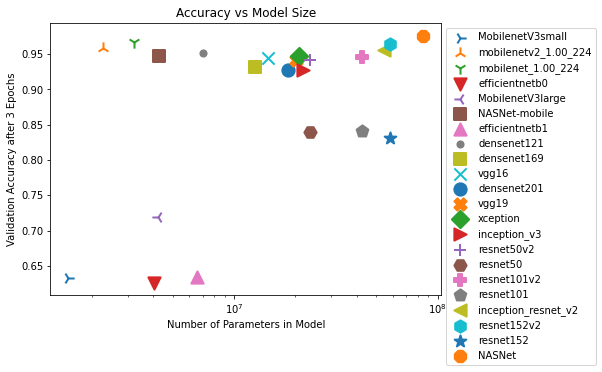

In [20]:
# Loop over each row and plot the num_model_params vs validation_accuracy
markers=[".",",","o","v","^","<",">","1","2","3","4","8","s","p","P","*","h","H","+","x","X","D","d","|","_",4,5,6,7,8,9,10,11]
plt.figure(figsize=(7,5))

for row in benchmark_df.itertuples():
    plt.scatter(row.num_model_params, row.validation_accuracy, label=row.model_name, marker=markers[row.Index], s=150, linewidths=2)
    
plt.xscale('log')
plt.xlabel('Number of Parameters in Model')
plt.ylabel('Validation Accuracy after 3 Epochs')
plt.title('Accuracy vs Model Size')

# Move legend out of the plot
plt.legend(bbox_to_anchor=(1, 1), loc='upper left');